# Detecting Lung Disease Using CNNs

In [10]:
%matplotlib inline

import os
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from PIL import Image
from keras.applications import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.models import Model
from keras.layers import Flatten
from keras.layers import Dense
from keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt

## Loading in the Data
This section of code opens the files that contain information about each scan. The first file contains all of the names of the images we will use for training, the second file contains all of the names of the images we will use for testing. The third file contains the metadata for each image (patient id, gender, age, etc.).

In [2]:
data_path = './xray_data/'

# get all names of train images (86,524 training images)
train_names_file = open(data_path + 'train_val_list.txt', 'r')
train_names = [name.strip() for name in train_names_file.readlines()][:2000]
train_names_file.close()

# get all names of test images (25,596 testing images)
test_names_file = open(data_path + 'test_list.txt', 'r')
test_names = [name.strip() for name in test_names_file.readlines()][:500]
test_names_file.close()

# read data file
info_file = open(data_path + 'Data_Entry_2017.csv')
info = info_file.readlines()
info_file.close()

# read bounding box file
bb_file = open(data_path + 'BBox_List_2017.csv')
bb_coords = [coords.strip().split(',') for coords in bb_file.readlines()[1:]]
bb_file.close()

What I would like to do now is define `x_train`, `x_test`, `y_train`, and `y_test`. `x_train` will be all of the training images and should be of shape `(86524, 1024, 1024, 3)`, `y_train` will be all of the diagnoses corresponding to each training image and should be of shape `(86524, 14)`. `x_test` will be all of the testing images and should be of shape `(25596, 1024, 1024, 3)`, `y_test` will be all of the diagnoses corresponding to each testing image and should be of shape `(25596, 14)`. 

In [3]:
# get list of paths for all training and testing images
train_path_list = []
test_path_list = []
for i in range(1, 13):
    image_folder = data_path + 'images_{0:03}'.format(i) + '/images/'
    for image_name in os.listdir(image_folder):
        if image_name in train_names:
            train_path_list.append(image_folder + image_name)
        elif image_name in test_names:
            test_path_list.append(image_folder + image_name)

I am having to do a bit of heuristics here because there are some images that are of shape (1024, 1024, 4) when all images should be of shape (1024, 1024). I am guessing there is most likely a better way to go around this but since I am not aware of what that would be at the moment, we are going with heuristics. 

In [4]:
# convert images to numpy array
train_images = []
test_images = []
names_included_train= []
names_included_test = []

# collects training images in an array
for img in train_path_list:
    train_img = np.asarray(Image.open(img))
    if train_img.shape == (1024, 1024):
        train_images.append(preprocess_input(train_img))
        names_included_train.append(img.split('/')[-1])
# collects testing images in an array
for img in test_path_list:
    test_img = np.asarray(Image.open(img))
    if test_img.shape == (1024, 1024):
        test_images.append(preprocess_input(test_img))
        names_included_test.append(img.split('/')[-1])
        
        
x_train = np.asarray(train_images) # converts list of training images into numpy array
x_train = np.repeat(x_train[..., np.newaxis], 3, -1) # convert to 'rgb'

x_test = np.asarray(test_images) # converts list of testing images into numpy array
x_test = np.repeat(x_test[..., np.newaxis], 3, -1) # convert to 'rgb'

In [5]:
# changes diagnoses to an integer coding
diagnoses_dict = {"No Finding": 0,
                  "Atelectasis": 1,
                  "Consolidation": 2,
                  "Infiltration": 3,
                  "Pneumothorax": 4,
                  "Edema": 5,
                  "Emphysema": 6,
                  "Fibrosis": 7,
                  "Effusion": 8,
                  "Pneumonia": 9,
                  "Pleural_Thickening": 10,
                  "Cardiomegaly": 11,
                  "Mass": 12,
                  "Nodule": 13,
                  "Hernia": 14
                 }

# creates a dictionary that matches an image to its diagnosis
name_to_name = {}
for lst in info[1:]:
    new_lst = lst.strip().split(',')
    name = new_lst[0]
    diagnoses = new_lst[1].split('|')
    name_to_name[name] = diagnoses
    
# creates a dictionary that matches an image to its corresponding diagnosis integer
info_dict = {}
for name in name_to_name:
    diag_names = name_to_name[name]
    info_dict[name] = [diagnoses_dict[diag_name] for diag_name in diag_names]

In [6]:
y_train = np.zeros((x_train.shape[0], len(diagnoses_dict)))
y_test = np.zeros((x_test.shape[0], len(diagnoses_dict)))
for name_idx, name in enumerate(names_included_train):
    diagnoses = info_dict[name]
    for diag_idx in range(len(y_train[name_idx])):
        if diag_idx in diagnoses:
            y_train[name_idx, diag_idx] = 1


## Creating the Model
Next, I am going to create the model that will train on the Chest X-Rays. I am going to start with a pre-trained network and see if that helps training go more smoothly. I am using categorical crossentropy as my loss function to allow for multiple labels being present. I also use sigmoid activation to accommodate multiple labels. 

In [7]:
# load model without classifier layers
model = DenseNet121(include_top=False, input_shape=(1024, 1024, 3), weights='imagenet', pooling='max')

# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='sigmoid')(flat1)
output = Dense(15, activation='sigmoid')(class1)

# define new model
model = Model(inputs=model.inputs, outputs=output)

for layer in model.layers[:-2]:
    layer.trainable=False
    
model.compile(loss=[tfa.losses.SigmoidFocalCrossEntropy()], metrics=["accuracy"], optimizer='adam')
history = model.fit(x_train, y_train, batch_size=64, epochs=5)

Epoch 1/5
31/31 [==============================] - 8997s 289s/step - loss: 0.8339 - accuracy: 0.4544
Epoch 2/5
31/31 [==============================] - 8982s 290s/step - loss: 0.3497 - accuracy: 0.5763
Epoch 3/5
31/31 [==============================] - 9361s 303s/step - loss: 0.3116 - accuracy: 0.5708
Epoch 4/5
31/31 [==============================] - 9096s 293s/step - loss: 0.2985 - accuracy: 0.5640
Epoch 5/5
31/31 [==============================] - 9154s 295s/step - loss: 0.2912 - accuracy: 0.5695


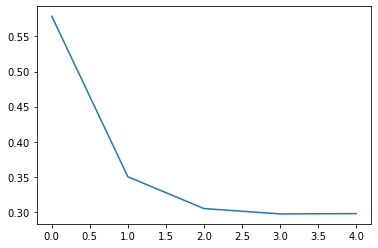

In [12]:
plt.plot(history.history['loss'])

In [13]:
model.evaluate(x_test, y_test)

16/16 [==============================] - 1101s 68s/step - loss: 0.1159 - accuracy: 1.0000


[0.11587262153625488, 1.0]